In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving yelp.csv to yelp.csv


In [ ]:
df = pd.read_csv('yelp.csv')

In [ ]:
# Create a new column representing the number of words in text 
df['length'] = df.apply(lambda x: len(x['text']), axis=1)

# EDA

<Axes: xlabel='stars', ylabel='length'>

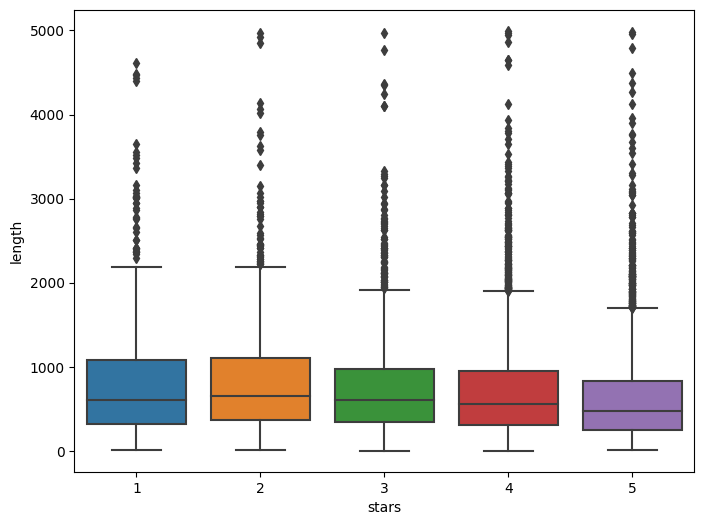

In [ ]:
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='stars',y='length',data=df)

Text(0.5, 1.0, 'Total count for each star')

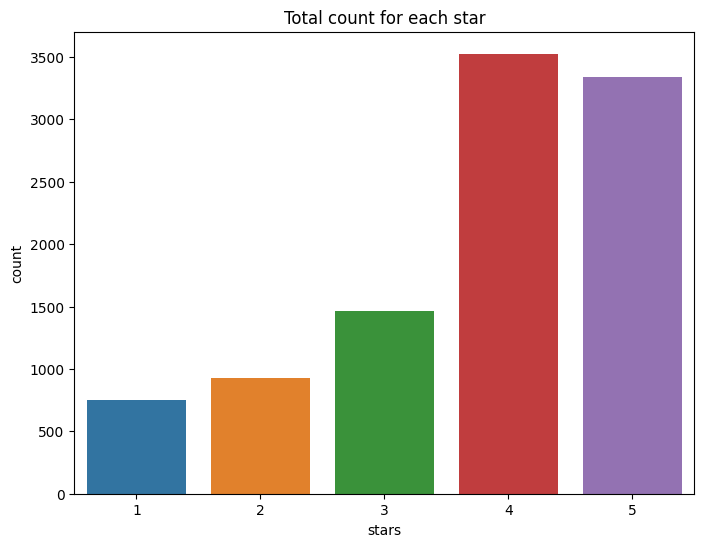

In [ ]:
# Histogram
plt.figure(figsize=(8,6))
sns.countplot(x='stars', data=df)
plt.title('Total count for each star')

<Axes: >

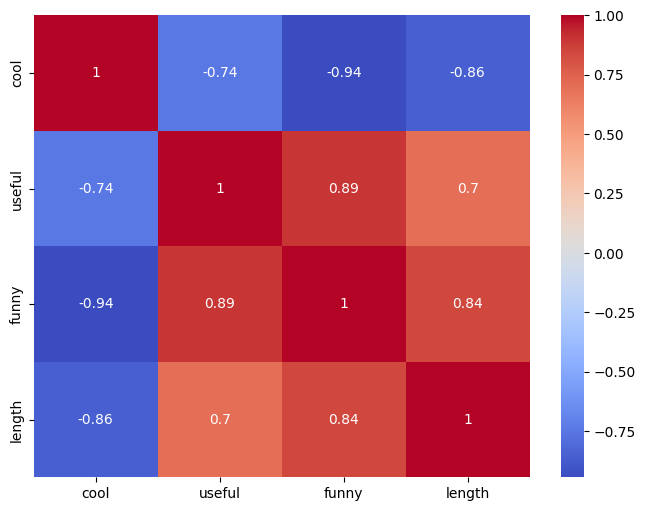

In [ ]:
# Correlation Heatmap
stars = df.groupby('stars').mean()
plt.figure(figsize=(8,6))
sns.heatmap(stars.corr(), cmap='coolwarm', annot=True)

In [ ]:
# drop unnecessary columns
df.drop(columns=['user_id', 'business_id', 'date', 'review_id'], inplace=True)

In [ ]:
# create a copy of df (not apply embeddings & stopwords for BERT)
df_copy = df.copy()

# Text Cleaning

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
my_stop_words = set(stopwords.words('english') + ['super', 'duper', 'place'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.tokenize import word_tokenize
def clear_text(data):
    cleaned_text=[]
    for sentences in data['text']:
        sentences = sentences.lower()
        sentences = word_tokenize(sentences)
        new_sentences = []
        for word in sentences:
            if word.isalpha() and word not in my_stop_words:
                new_sentences.append(word)
                new_text = ' '.join(new_sentences)
        cleaned_text.append(new_text)
    return cleaned_text

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df['text'] = clear_text(df)

In [ ]:
df.head(5)

,stars,text,type,cool,useful,funny,length
0,5,wife took birthday breakfast excellent weather...,review,2,5,0,889
1,5,idea people give bad reviews goes show please ...,review,0,0,0,1345
2,4,love gyro plate rice good also dig candy selec...,review,0,1,0,76
3,5,rosie dakota love chaparral dog park convenien...,review,1,2,0,419
4,5,general manager scott petello good egg go deta...,review,0,0,0,469


# Sentiment Analysis

In [ ]:
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#download the list of positive and negative words 
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list
    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

#calculate the percentage of positive and negative words in each review
def get_sentiment(texts):
    results=[]
    count = 0
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    for text in texts:
        pos = neg = 0
        for word in word_tokenize(text):
            if word in positive_words:
                pos += 1
            if word in negative_words:
                neg += 1
        count +=1
        results.append((count,100*pos/len(word_tokenize(text)),100*neg/len(word_tokenize(text))))
    return results

In [ ]:
sentiments=get_sentiment(df['text'])
df['pos%'] = [0] * 10000
df['neg%'] = [0] * 10000
for i in range(10000):
    df.loc[i,'pos%'] = sentiments[i][1]
    df.loc[i,'neg%'] = sentiments[i][2]

Text(0.5, 0, 'Positive Words Percentage%')

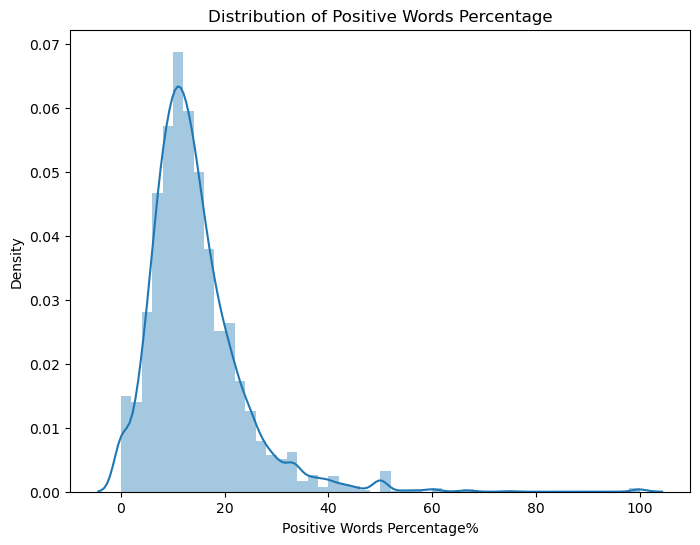

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(df['pos%'])
plt.title('Distribution of Positive Words Percentage')
plt.xlabel('Positive Words Percentage%')

Text(0.5, 0, 'Negative Words Percentage%')

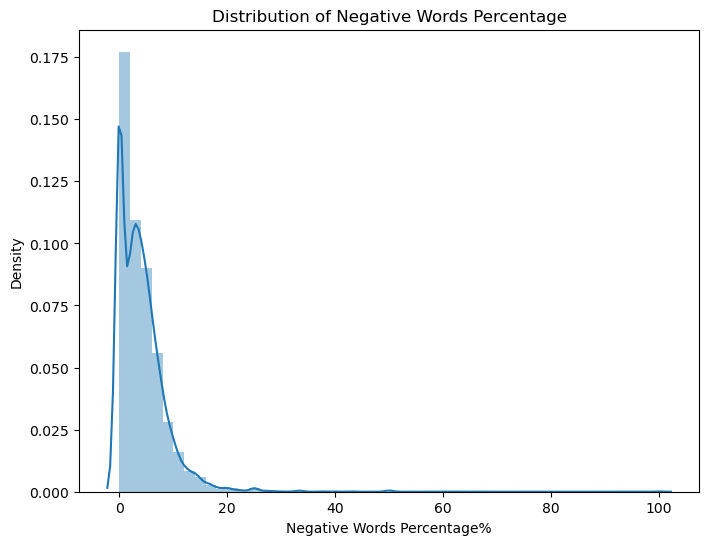

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(df['neg%'])
plt.title('Distribution of Negative Words Percentage')
plt.xlabel('Negative Words Percentage%')

In [ ]:
#plot percentage against rating
one = df[df['stars']==1]
two = df[df['stars']==2]
three = df[df['stars']==3]
four = df[df['stars']==4]
five = df[df['stars']==5]
pos_mean=[]
neg_mean=[]
for i in [one,two,three,four,five]:
    pos_mean.append(i['pos%'].mean())
    neg_mean.append(i['neg%'].mean())

<Figure size 800x600 with 0 Axes>

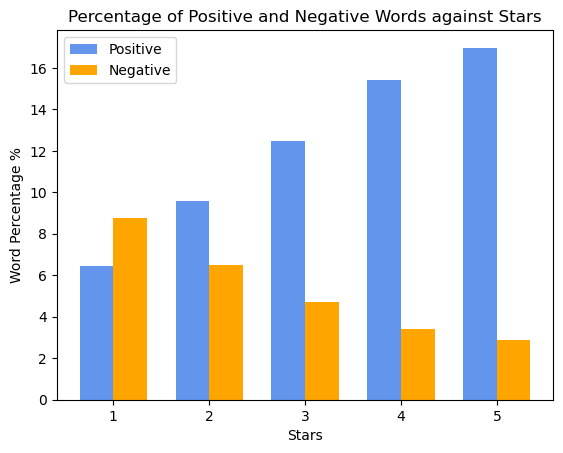

In [ ]:
x_labels=['1','2','3','4','5']

plt.figure(figsize=(8,6))
bar_width = 0.35
# Create positions for the two bars for each x value
x_pos = np.arange(len(x_labels))

# Create bar chart with two sets of data for each x value
fig, ax = plt.subplots()
ax.bar(x_pos - bar_width/2, pos_mean, width=bar_width, color='cornflowerblue', label='Positive')
ax.bar(x_pos + bar_width/2, neg_mean, width=bar_width, color='orange', label='Negative')

# Add legend and labels
ax.legend()
ax.set_xlabel('Stars')
ax.set_ylabel('Word Percentage %')
ax.set_title('Percentage of Positive and Negative Words against Stars')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)

# Show the plot
plt.show()

In [ ]:
#find correlation between percentage and rating
pos_corr = df['pos%'].corr(df['stars'])
neg_corr = df['neg%'].corr(df['stars'])
print("The correlation between positive words percentage and stars is:", pos_corr)
print("The correlation between negative words percentage and stars is:", neg_corr)

The correlation between positive words percentage and stars is: 0.34132996860476916
The correlation between negative words percentage and stars is: -0.34836508940089556


In [ ]:
#try to run a logistic regression of rating only based on text sentiment (two variables: pos% and neg%)
from sklearn.model_selection import train_test_split
xx=df[['pos%','neg%']]
yy=df['stars']
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.3,random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
log_senti = LogisticRegression()
log_senti.fit(X_train, y_train)
y_pred = log_senti.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[[107   6   0  99   6]
 [ 53  15   5 174  18]
 [ 34   5   1 320  82]
 [ 24   4   3 696 360]
 [ 26   2   1 531 428]]


              precision    recall  f1-score   support

           1       0.44      0.49      0.46       218
           2       0.47      0.06      0.10       265
           3       0.10      0.00      0.00       442
           4       0.38      0.64      0.48      1087
           5       0.48      0.43      0.45       988

    accuracy                           0.42      3000
   macro avg       0.37      0.32      0.30      3000
weighted avg       0.38      0.42      0.37      3000

Accuracy: 0.4156666666666667


# Topic Analysis

In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [ ]:
#only check two extreme groups
one = df[df['stars']==1]['text']
five = df[df['stars']==5]['text']

In [ ]:
# get three topics for each group, each topic contains 10 words
def get_topic(letter):
    dict = {}
    count =0
    for i in letter:
    # remove frequent words that are not very topic related
        texts = [[word for word in doc.split() if word not in ['got','went','one','like','would','good','great','get','know','go','us','also','really','always','could','ordered']]
            for doc in list(i)]
        dictionary = corpora.Dictionary(texts)
        corpus = [dictionary.doc2bow(text) for text in texts]
        lda = LdaModel(corpus,
                       id2word=dictionary,
                      num_topics=3,
                      passes=10)
        count+=1
        dict[count]=(lda.show_topic(0), lda.show_topic(1),lda.show_topic(2))
    return lda, dict

In [ ]:
def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        # topn means show at most 50 topic words
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue
#         freq = int(prob/prob_total*1000)
        freq = int(prob/prob_total*100)
        alist=[word]
        word_list.extend(alist*freq)
        # just show the frequency of the word appeared in the list
        
#     print(word_list)
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    from random import shuffle
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return None

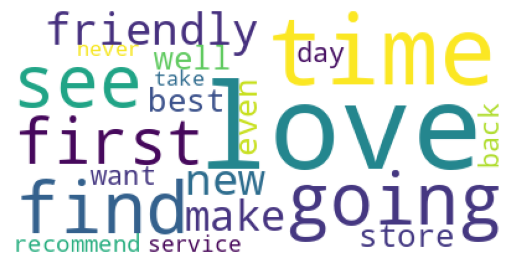

In [ ]:
# Most frequent words of rating=5
draw_wordcloud(get_topic([five])[0],2)

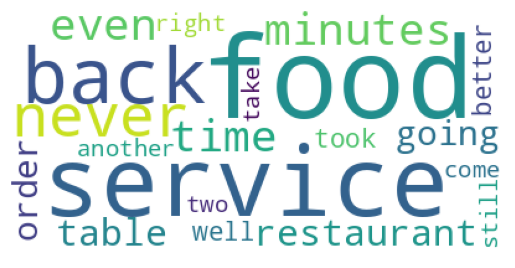

In [ ]:
# Most frequent words of rating=1
draw_wordcloud(get_topic([one])[0],2)

In [ ]:
get_topic([one,five])[1]

{1: ([('food', 0.009976819),
   ('service', 0.0071576927),
   ('time', 0.0058154007),
   ('even', 0.0049333097),
   ('never', 0.0044549103),
   ('back', 0.004120936),
   ('people', 0.004115731),
   ('minutes', 0.003578041),
   ('say', 0.00345444),
   ('going', 0.0034535439)],
  [('food', 0.011381556),
   ('back', 0.005803368),
   ('service', 0.0056182877),
   ('never', 0.004649402),
   ('bad', 0.0040998273),
   ('time', 0.0040804422),
   ('order', 0.0037095374),
   ('even', 0.0034741736),
   ('store', 0.0031595903),
   ('right', 0.0030587965)],
  [('food', 0.008731762),
   ('back', 0.0064309817),
   ('even', 0.0055312677),
   ('time', 0.0052458583),
   ('minutes', 0.0049115606),
   ('said', 0.0044605765),
   ('asked', 0.004316174),
   ('order', 0.0041216332),
   ('service', 0.003878205),
   ('never', 0.0035011175)]),
 2: ([('food', 0.0125066545),
   ('service', 0.005683111),
   ('time', 0.0051038414),
   ('coffee', 0.0043051476),
   ('well', 0.0041679614),
   ('chicken', 0.004001379),


# Model Building

# 1.BERT

In [ ]:
#BERT doesn't require text to be cleaned
X = df_copy['text']
y = df_copy['stars']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

# Shift ratings from 1-5 to 0-4 for indexing purposes
y_train = [rating - 1 for rating in y_train]
y_test = [rating - 1 for rating in y_test]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
# Tokenize the input dat
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length = 512, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length = 512,return_tensors="pt")

# Convert the tokenized data into TensorDataset
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test, dtype=torch.long))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [ ]:
train_dataset

In [ ]:
# Fine-tune the BERT model using the training data
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

optim = torch.optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 2 

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        input_ids, attention_mask, labels = [tensor.to(device) for tensor in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

In [ ]:
# Predict ratings for the test data
model.eval()
predictions = []

with torch.no_grad():
    for input_ids, attention_mask, _ in test_dataset:
        input_ids = input_ids.to(device).unsqueeze(0)
        attention_mask = attention_mask.to(device).unsqueeze(0)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()
        predictions.append(prediction)  


In [ ]:
# Calculate the accuracy score
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))
accuracy = accuracy_score(y_test, predictions)
print(f"Test accuracy: {accuracy:.4f}")

[[166  29  12   7   4]
 [ 93 102  34  30   6]
 [ 15  58 136 202  31]
 [ 12   6  50 669 350]
 [  9   4   3 218 754]]


              precision    recall  f1-score   support

           0       0.56      0.76      0.65       218
           1       0.51      0.38      0.44       265
           2       0.58      0.31      0.40       442
           3       0.59      0.62      0.60      1087
           4       0.66      0.76      0.71       988

    accuracy                           0.61      3000
   macro avg       0.58      0.57      0.56      3000
weighted avg       0.60      0.61      0.60      3000

Test accuracy: 0.6090


In [ ]:
f1 = f1_score(y_test, predictions, average='weighted')
print(f1)

0.5969625535551811


<Axes: >

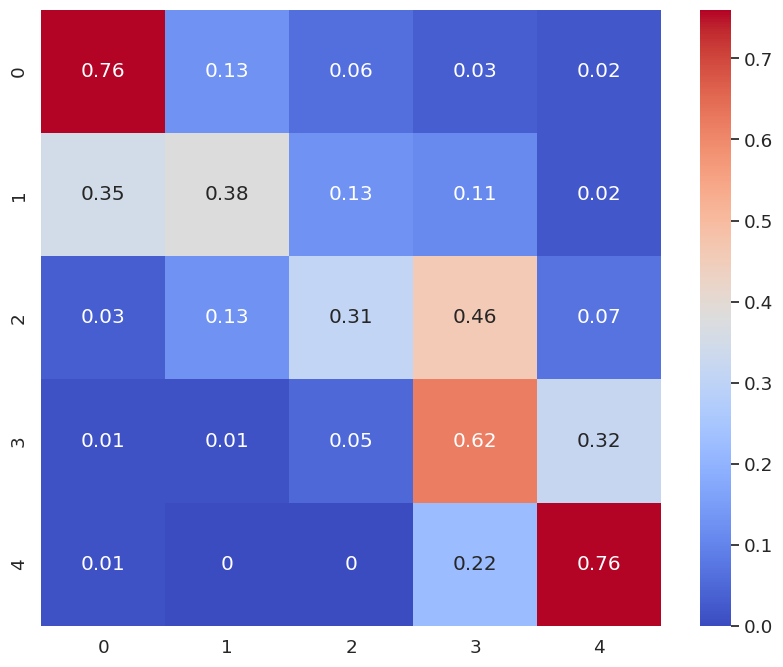

In [ ]:
# plot confusion matrix heatmap
matrix = confusion_matrix(y_test,predictions)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
matrix = np.round(matrix, 2)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(matrix, cmap='coolwarm', annot=True)

# 2. XGBoost

In [ ]:
X = df['text']
y = df['stars']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
y_train = [rating - 1 for rating in y_train]
y_test = [rating - 1 for rating in y_test]

In [ ]:
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.5, 0.7],
    'n_estimators': [200, 300]
}
xgb_clf = XGBClassifier(use_label_encoder=False,verbosity=0)
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy')

# Train the classifier using the training data
grid_search.fit(X_train_tfidf, y_train)

# Predict the ratings on the test data
y_pred_xgb= grid_search.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarnin

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}

In [ ]:
# Create an XGBoost classifier
xgb_clf = XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=300, use_label_encoder=False)

# Train the classifier using the training data
xgb_clf.fit(X_train_tfidf, y_train)

# Predict the ratings on the test data
y_pred_xgb= xgb_clf.predict(X_test_tfidf)

print(y_pred_xgb[:100])

C:\Users\sl5197\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[3 4 3 1 4 3 4 4 4 1 4 3 4 3 4 2 4 4 4 4 3 3 0 3 4 3 4 3 2 0 3 4 3 3 3 4 4
 3 3 4 4 4 3 4 3 4 3 4 3 0 4 4 3 3 3 3 3 4 4 4 0 2 3 3 4 3 4 4 1 4 3 0 3 4
 2 4 3 4 4 3 4 3 2 3 2 4 1 2 4 3 3 2 4 3 3 4 3 4 3 3]


In [ ]:
# Calculate the accuracy score
print(confusion_matrix(y_test,y_pred_xgb))
print('\n')
print(classification_report(y_test,y_pred_xgb))
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

[[ 82  21  25  41  49]
 [ 35  48  61  90  31]
 [ 12  17  97 260  56]
 [  5   8  56 650 368]
 [  3   2  10 299 674]]


              precision    recall  f1-score   support

           0       0.60      0.38      0.46       218
           1       0.50      0.18      0.27       265
           2       0.39      0.22      0.28       442
           3       0.49      0.60      0.54      1087
           4       0.57      0.68      0.62       988

    accuracy                           0.52      3000
   macro avg       0.51      0.41      0.43      3000
weighted avg       0.51      0.52      0.50      3000

Accuracy: 0.517


In [ ]:
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
print(f"F1 score is {f1:5.4f}")

F1 score is 0.4975


<AxesSubplot:>

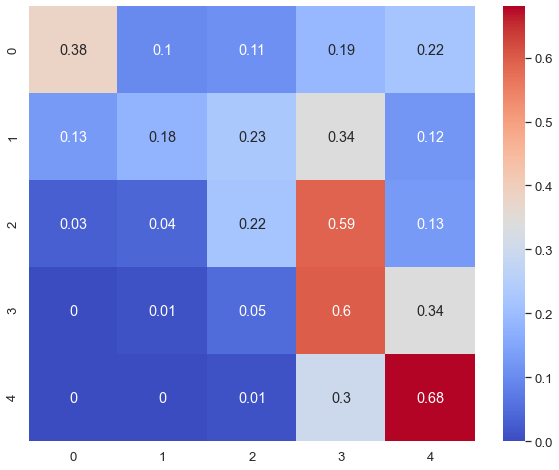

In [ ]:
# plot confusion matrix heatmap
matrix = confusion_matrix(y_test,y_pred_xgb)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
matrix = np.round(matrix, 2)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(matrix, cmap='coolwarm', annot=True)

# 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [400],
    'max_depth': [30, 40, 50],
    'min_samples_split': [3, 5, 8],
    'min_samples_leaf': [6, 8, 10]
}
# Create a Random Forest classifier
rf_clf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy',verbose = 0)
# Train the classifier using the training data
grid_search_rf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [30, 40, 50],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [3, 5, 8],
                         'n_estimators': [400]},
             scoring='accuracy')

In [ ]:
# Predict the ratings on the test data
y_pred_rf = grid_search_rf.predict(X_test_tfidf)

In [ ]:
grid_search_rf.best_params_

{'max_depth': 40,
 'min_samples_leaf': 8,
 'min_samples_split': 3,
 'n_estimators': 400}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(max_depth=40, min_samples_leaf=8, min_samples_split=3, n_estimators=400)

# Train the classifier using the training data
rf_clf.fit(X_train_tfidf, y_train)

# Predict the ratings on the test data
y_pred_rf = rf_clf.predict(X_test_tfidf)

print(y_pred_rf)

[3 4 4 ... 4 3 3]


In [ ]:
# Calculate the accuracy score
print(confusion_matrix(y_test,y_pred_rf))
print('\n')
print(classification_report(y_test,y_pred_rf))
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

[[  0   0   0 124  94]
 [  0   0   0 205  60]
 [  0   0   0 378  64]
 [  0   0   0 753 334]
 [  0   0   0 339 649]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       218
           1       0.00      0.00      0.00       265
           2       0.00      0.00      0.00       442
           3       0.42      0.69      0.52      1087
           4       0.54      0.66      0.59       988

    accuracy                           0.47      3000
   macro avg       0.19      0.27      0.22      3000
weighted avg       0.33      0.47      0.38      3000

Accuracy: 0.4673333333333333


C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f1 = f1_score(y_test, y_pred_rf, average='weighted')
print(f"F1 score is {f1:5.4f}")

F1 score is 0.3844


<AxesSubplot:>

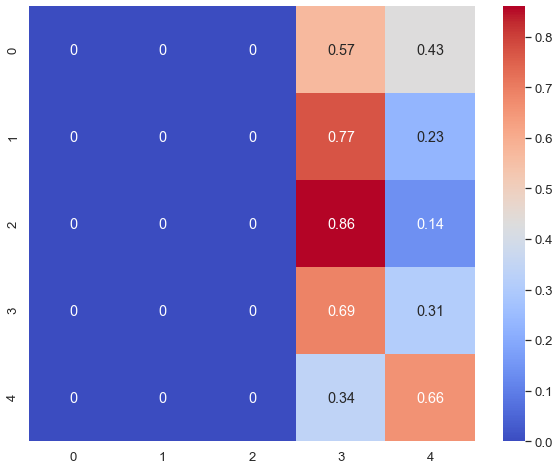

In [ ]:
# plot confusion matrix heatmap
matrix = confusion_matrix(y_test,y_pred_rf)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
matrix = np.round(matrix, 2)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(matrix, cmap='coolwarm', annot=True)

# 4. SVM

In [ ]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [1,0.1,0.01]
}
svm_clf = SVC()
grid_search_svm = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy',verbose = 0)
# Train the classifier using the training data
grid_search_svm.fit(X_train_tfidf, y_train)

# Predict the ratings on the test data
y_pred_svm = grid_search_svm.predict(X_test_tfidf)

In [ ]:
grid_search_svm.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

In [ ]:
# Calculate the accuracy score
print(confusion_matrix(y_test,y_pred_svm))
print('\n')
print(classification_report(y_test,y_pred_svm))
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)

[[105  37  21  32  23]
 [ 34  90  59  62  20]
 [ 11  32 125 228  46]
 [  6  15  57 686 323]
 [  7   4  17 311 649]]


              precision    recall  f1-score   support

           1       0.64      0.48      0.55       218
           2       0.51      0.34      0.41       265
           3       0.45      0.28      0.35       442
           4       0.52      0.63      0.57      1087
           5       0.61      0.66      0.63       988

    accuracy                           0.55      3000
   macro avg       0.55      0.48      0.50      3000
weighted avg       0.55      0.55      0.54      3000

Accuracy: 0.5516666666666666


In [ ]:
f1 = f1_score(y_test, y_pred_svm, average='weighted')
print(f"F1 score is {f1:5.4f}")

F1 score is 0.5423


<AxesSubplot:>

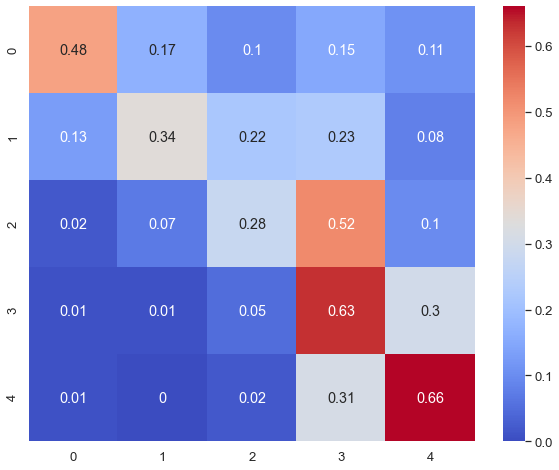

In [ ]:
# plot confusion matrix heatmap
matrix = confusion_matrix(y_test,y_pred_svm)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
matrix = np.round(matrix, 2)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(matrix, cmap='coolwarm', annot=True)

# 5. Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Create a Naive Bayes classifier
nb_clf = MultinomialNB()

# Train the classifier using the training data
nb_clf.fit(X_train_tfidf, y_train)

# Predict the ratings on the test data
y_pred_nb = nb_clf.predict(X_test_tfidf)

In [ ]:
# Calculate the accuracy score
print(confusion_matrix(y_test,y_pred_nb))
print('\n')
print(classification_report(y_test,y_pred_nb))
accuracy = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy)

[[  0   0   0 186  32]
 [  0   0   0 243  22]
 [  0   0   0 420  22]
 [  0   0   0 983 104]
 [  0   0   0 670 318]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       218
           2       0.00      0.00      0.00       265
           3       0.00      0.00      0.00       442
           4       0.39      0.90      0.55      1087
           5       0.64      0.32      0.43       988

    accuracy                           0.43      3000
   macro avg       0.21      0.25      0.20      3000
weighted avg       0.35      0.43      0.34      3000

Accuracy: 0.43366666666666664


C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f1 = f1_score(y_test, y_pred_nb, average='weighted')
print(f"F1 score is {f1:5.4f}")

F1 score is 0.3394


<AxesSubplot:>

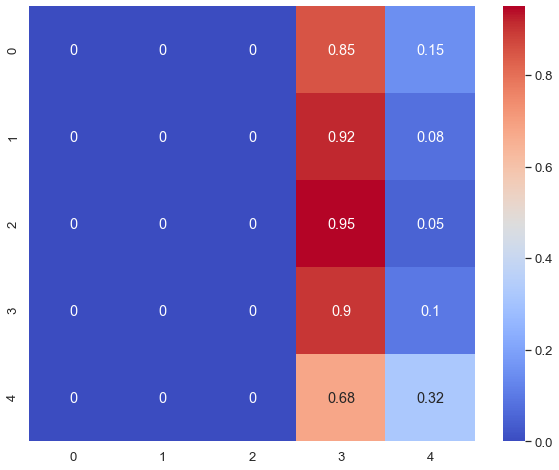

In [ ]:
# plot confusion matrix heatmap
matrix = confusion_matrix(y_test,y_pred_nb)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
matrix = np.round(matrix, 2)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(matrix, cmap='coolwarm', annot=True)

# 6. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

param_grid = {
    'C': [1,2,3,4],
    'solver': ['lbfgs', 'liblinear', 'sag'],
}
lr_clf = LogisticRegression()
grid_search_lr = GridSearchCV(lr_clf, param_grid, cv=5, scoring='accuracy',verbose = 0)
grid_search_lr.fit(X_train_tfidf, y_train)

# Predict the ratings on the test data
y_pred_lr = grid_search_lr.predict(X_test_tfidf)

In [ ]:
grid_search_lr.best_params_

{'C': 2, 'solver': 'sag'}

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(C=2, solver='sag')
lr_clf.fit(X_train_tfidf, y_train)
y_pred_lr = lr_clf.predict(X_test_tfidf)

In [ ]:
# Calculate the accuracy score
print(confusion_matrix(y_test,y_pred_lr))
print('\n')
print(classification_report(y_test,y_pred_lr))
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:5.4f}")

[[ 93  34  21  34  36]
 [ 33  64  69  67  32]
 [  7  26 117 228  64]
 [  3   8  57 669 350]
 [  3   2  11 320 652]]


              precision    recall  f1-score   support

           0       0.67      0.43      0.52       218
           1       0.48      0.24      0.32       265
           2       0.43      0.26      0.33       442
           3       0.51      0.62      0.56      1087
           4       0.57      0.66      0.61       988

    accuracy                           0.53      3000
   macro avg       0.53      0.44      0.47      3000
weighted avg       0.53      0.53      0.52      3000

Accuracy: 0.5317


In [ ]:
f1 = f1_score(y_test, y_pred_lr, average='weighted')
print(f"F1 score is {f1:5.4f}")

F1 score is 0.5186


<AxesSubplot:>

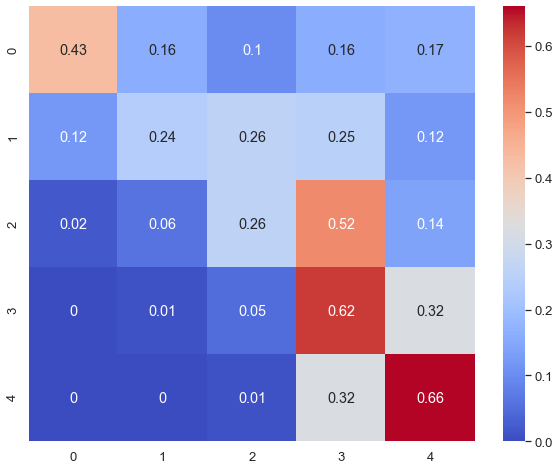

In [ ]:
# plot confusion matrix heatmap
matrix = confusion_matrix(y_test,y_pred_lr)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
matrix = np.round(matrix, 2)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(matrix, cmap='coolwarm', annot=True)

# Feature Importance (SVC)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Select the top k features using chi-square feature selection
k = 23779
selector = SelectKBest(chi2, k=k)
X_train_new = selector.fit_transform(X_train_tfidf, y_train)

In [ ]:
svm_best = SVC(C=1, kernel='linear', gamma=0.1)
svm_best.fit(X_train_tfidf, y_train)
coefs = svm_best.coef_

In [ ]:
feature_importance = np.abs(coefs.toarray())[0]
feature_names = np.array(vectorizer.get_feature_names_out())[selector.get_support()]
most_important_words = feature_names[np.argsort(feature_importance)[::-1]][:10]

In [ ]:
print('The most important words that contribute to the predictions are:')
list(most_important_words)

The most important words that contribute to the predictions are:


['horrible',
 'good',
 'awful',
 'stars',
 'great',
 'nasty',
 'disgusting',
 'minutes',
 'customer',
 'total']

## Conlusion

Summary of the machine learning models and accuracy:

|Model         |Accuracy|F-score|
|-------------:|-------:|------:|
|BERT          |0.6090  |0.5970 |
|XGBoost       |0.5170  |0.4975 |
|Random Forest |0.4673  |0.3844 |
|SVM           |0.5517  |0.5423 |
|Naive Bayes   |0.4337  |0.3394 |
|Logistic Reg  |0.5317  |0.5186 |

From this point, the NLP driven BERT model has the best fit for the YELP text data.